<h1>Kaggle's Titanic Survivor Data - Analysis by Phil Rongo</h1>

Kaggle provides data -- passenger data, along with predetermined training and testing splits -- that we will use to build a machine learning model to predict if a random passenger would survive the doomed voyage.

First, let's perform some data exploration and visualization to determine what kind of model we should use.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

data = pd.read_csv(r"./train.csv")

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Looks like we have a 12-feature dataframe. A good number of the features seem to be objects, but since we loaded this data from a CSV we know that they must be strings.

Looks like we're missing a fair amount of data for both the Age and Cabin features as well, in addition to a few observations for the Embarked feature. Let's do some more exploring to see how to handle this.

In [2]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Some prior information about the features of this dataset:
* Survival is a Bernoulli variable with 1 = Survived
* pclass represents a proxy for social class -> 1: upper class, 2: middle class, 3: lower class
* sibsp is an interpretation of family relationships on board:
    siblings: [brother, sister, stepbrother, stepsister]
    spouse: [husband, wife] (fiances/mistress ignored)
* parch defines parental relationships and will denote child or parent.



In [3]:
data['numeric_gender'] = data["Sex"].apply(lambda x: 1 if x == 'male' else 0)
corr_matrix = data.corr(numeric_only=True)
corr_matrix['Survived'].sort_values()

numeric_gender   -0.543351
Pclass           -0.338481
Age              -0.077221
SibSp            -0.035322
PassengerId      -0.005007
Parch             0.081629
Fare              0.257307
Survived          1.000000
Name: Survived, dtype: float64

Sex seems to be negatively correlated with survival. Since 1 is male and 0 is female, this means that, on the surface, it seems women were more likely to survive. Lets confirm this with a plot.

The pandas .agg() method is awesome. It allows you to perform functions on columns of a dataframe, and even perform different functions for different columns. Here is the link to the docs:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html

.agg returns:
* scalar when called on a series with a single function
* series when called on a dataframe with a single function
* dataframe when called wwith several functions or on multiple columns.

In [4]:
print(data.groupby("Sex").agg("sum")[['Survived']])

        Survived
Sex             
female       233
male         109


<Axes: xlabel='Sex', ylabel='Age'>

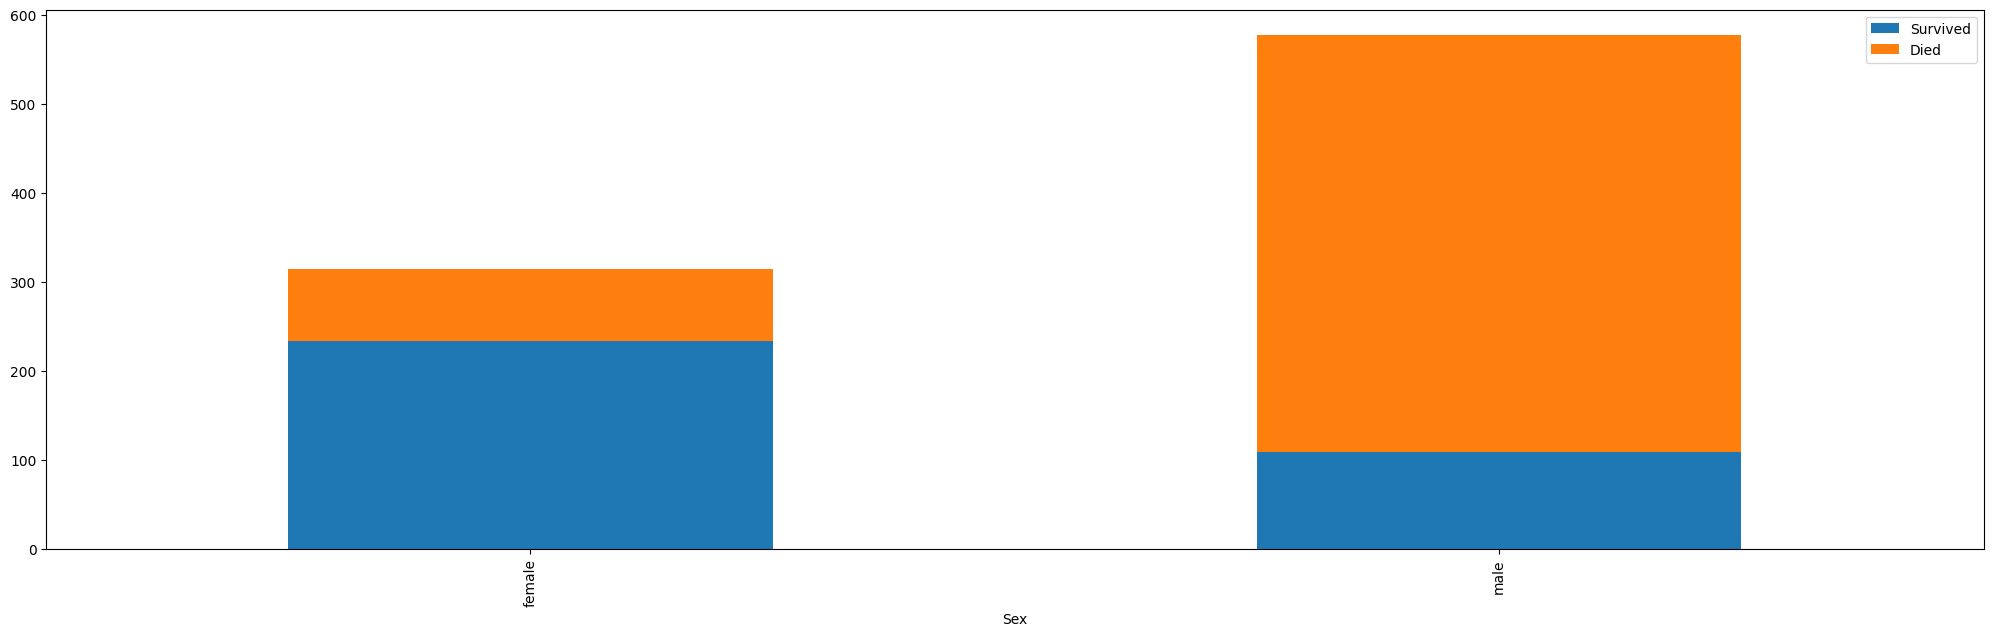

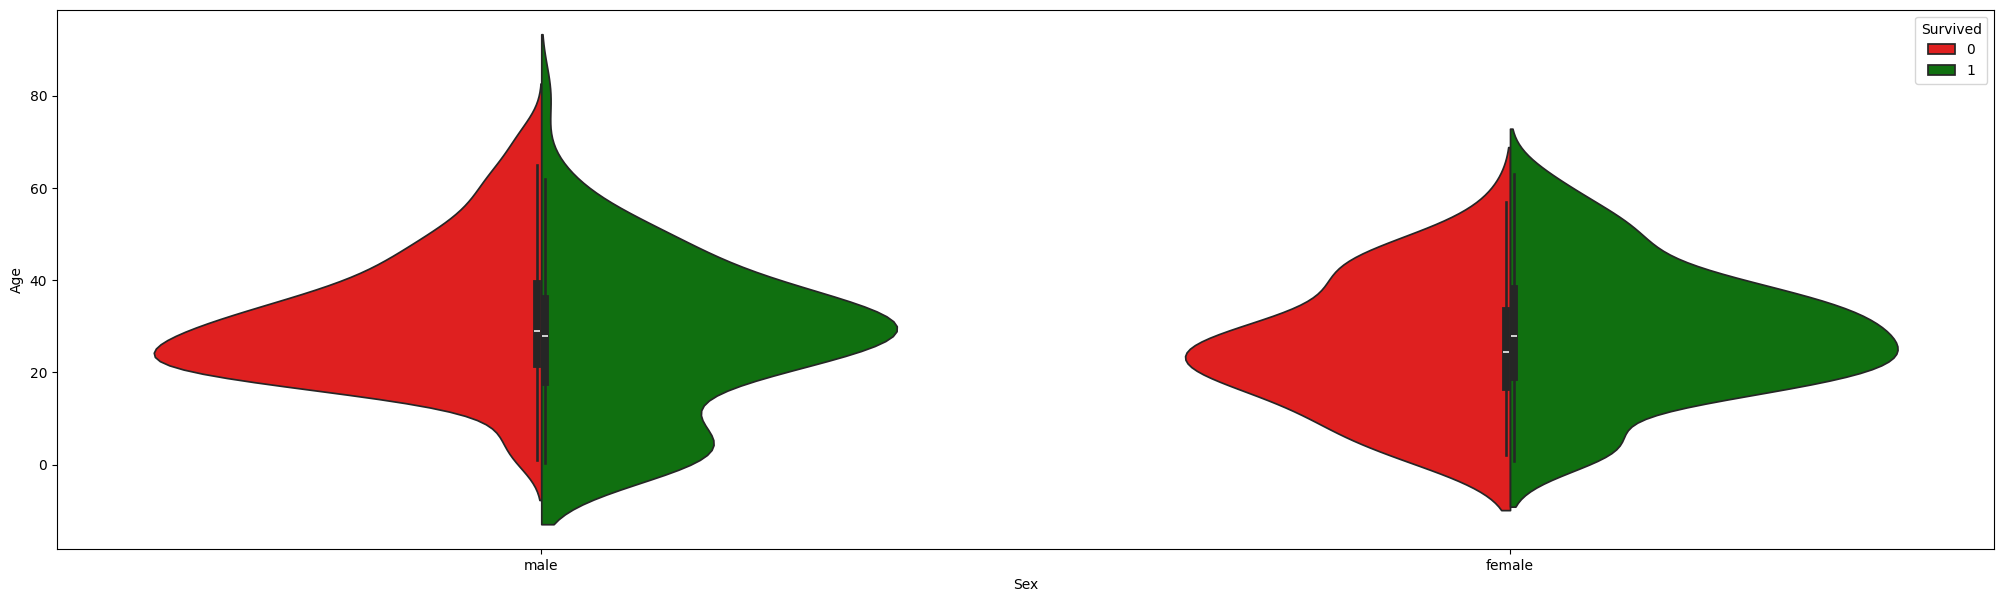

In [5]:
data['Died'] = 1 - data['Survived']
data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                           stacked=True)

fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=data, 
               split=True,
               palette={0: "r", 1: "g"}
              )
             

We can see quite obviously that women survive more than men, however neither are guaranteed to survive.

Judging from the violin chart, we can see that age seems to be relevant, especially for males.

From our correlation output above, it looks like social class and ticket fare also have something to do with survival. Let's take a look:

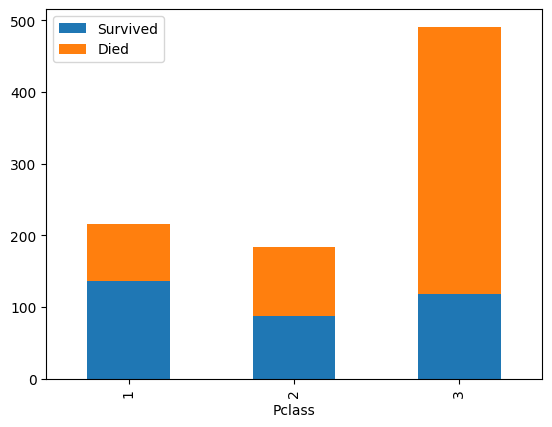

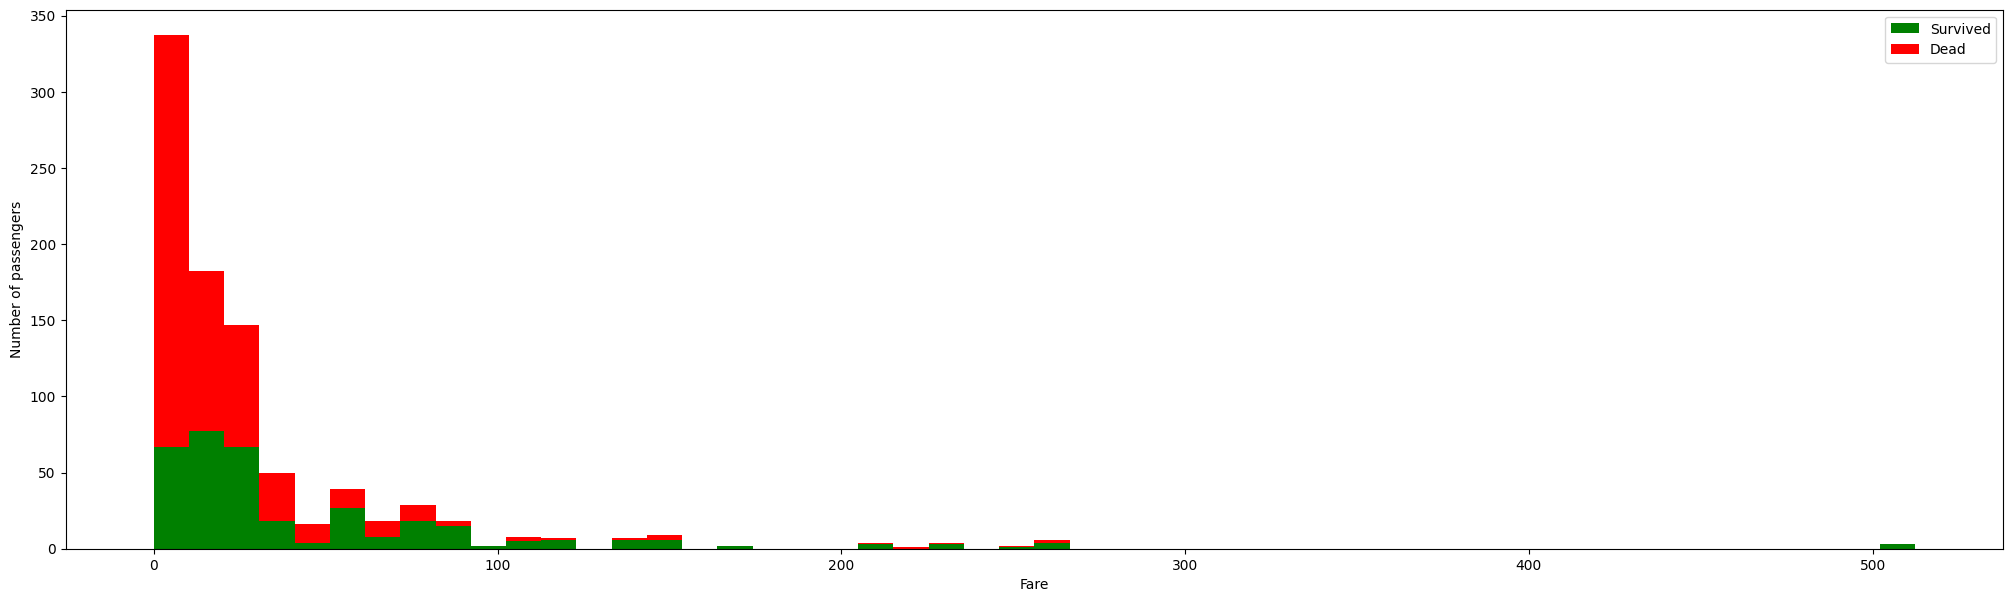

In [6]:
data.groupby('Pclass').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked=True)


figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend()

It looks like passengers with cheaper tickets were much more likely to pass away. 

<h1>Feature Engineering</h1>

We will append the training and test set together to add features to both sets, and then split them later.



In [7]:
def combineData():
    train = pd.read_csv("./train.csv")
    test = pd.read_csv("./test.csv")

    #remove target feature from the training set.
    #We do this so we can have a "clean" combined set.
    targets = train.Survived
    train.drop('Survived', axis=1, inplace=True)

    #merge the clean training data with the test data
    combined = pd.concat([train, test], axis=0)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'PassengerId'], inplace=True, axis=1)

    return combined, targets

combined, targets = combineData()

Awesome, now we have one large combined dataset for feature engineering, and a variable that saved our targets.



In [8]:
print(targets)

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64


Based on our exploratory data analysis from earlier, we know there are a few items that are more correllated with survival than others:

* Age
* Status
* Gender
* Fare (ticket price, related to status)

Let's look into prepping these features for our model.

<h3>Step 1- Age</h3>
Let's look at our combined dataframe very quickly:

In [9]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 102.4+ KB


Age seems to be missing a fair amount of values. We have a few approaches we can try to right this:

* Replace with the mean (not very accurate, skewed)
* Replace with the median (again, not very accurate)
* Replace by sorted median

Let me explain that last option. We can group our data by numerous factors (such as social class and gender) and fill the missing values based on the median of those groups. This will be far more accurate than just the mean or median of the whole dataset.

In [10]:
grouped_train = combined.iloc[:891].groupby(['Sex', 'Pclass'])
#Our training data is the first 890 rows of the combined
#set, so we'll focus on that when getting our median ages.
group_train_median = grouped_train['Age'].median()
group_train_median = group_train_median.reset_index()[['Sex', 'Pclass', 'Age']]
print(group_train_median)


      Sex  Pclass   Age
0  female       1  35.0
1  female       2  28.0
2  female       3  21.5
3    male       1  40.0
4    male       2  30.0
5    male       3  25.0


In [11]:
import numpy as np
def printRow(row):
    print(row)
    return 1

combined['Age'] = combined.apply(lambda row: group_train_median[(group_train_median['Pclass']==row['Pclass'])&(group_train_median['Sex']==row['Sex'])]['Age'].values[0]
               if np.isnan(row['Age'])
               else row['Age'], axis=1)
print(combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    1309 non-null   int64  
 1   Name      1309 non-null   object 
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   object 
 7   Fare      1308 non-null   float64
 8   Cabin     295 non-null    object 
 9   Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 102.4+ KB
None


Great. Now let's preprocess our Sex feature. It's hard for us to work with strings like "male" and "female", much easier to work with 1 and 0. Lets map male to 1 and female to 0.

In [12]:
combined['Sex'] = combined['Sex'].map({'male':1, "female":0})
print(combined.head())

   Pclass                                               Name  Sex   Age  \
0       3                            Braund, Mr. Owen Harris    1  22.0   
1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.0   
2       3                             Heikkinen, Miss. Laina    0  26.0   
3       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.0   
4       3                           Allen, Mr. William Henry    1  35.0   

   SibSp  Parch            Ticket     Fare Cabin Embarked  
0      1      0         A/5 21171   7.2500   NaN        S  
1      1      0          PC 17599  71.2833   C85        C  
2      0      0  STON/O2. 3101282   7.9250   NaN        S  
3      1      0            113803  53.1000  C123        S  
4      0      0            373450   8.0500   NaN        S  


Great, so now we have filled in the median ages by group and mapped sex to a binary value... Let's take stock. What else should we do?

* We see that Embarked, Pclass, and Cabin are categorical attributes. These will have to be encoded. But how?
    * To avoid our algorithm assuming similarity between closely-indexed values (assuming Embark port C is more similar to Q than it is to S, when in fact they are independent), we will use one-hot encoding for all of the features. 
* We should also work out some features based on family size. We can create a feature called Family Size out of "Parch" and "SibSp", and use it to one-hot encode different buckets of family sizes. We'll do this later


**For now, lets focus on encoding Embarked, Pclass, and Cabin**

<h3>Embarked:</h3>

In [13]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(sparse_output = False)

#We will fill any NA with the most common embark port, "S"

combined.Embarked.fillna("S", inplace=True)
embarktransform = onehotencoder.fit_transform(combined[['Embarked']])
embarktransform = pd.DataFrame(embarktransform, columns=onehotencoder.get_feature_names_out())
#get feature names out shows an annotated version of the feature fed in,
# annotated for each possible category



<h3>Processing Cabin</h3>

For missing cabin values, we will input "U" for unknown.


In [14]:
combined.Cabin.fillna("U", inplace=True)

#map each cabin to the first letter of it's name
combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])

#onehot encoding
cabintransform = onehotencoder.fit_transform(combined[['Cabin']])
cabintransform = pd.DataFrame(cabintransform, columns=onehotencoder.get_feature_names_out())



Ok. Now let's process Pclass. We'll use this as a proxy for fare since it is more generic.

In [15]:

pclasstransform = onehotencoder.fit_transform(combined[['Pclass']])

pclasstransform = pd.DataFrame(pclasstransform, columns=onehotencoder.get_feature_names_out())

print(combined.columns)


Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')


<h3> Processing Family Size </h3>

We will create a few new variables, defining the family size of parents + siblings (including the passenger themselves)

In [16]:
#Size of the family including passenger
combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1

#new variables based on family size
combined['SingleFamily'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if s >=2 else 0)
combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if s >=5 else 0)


In [17]:
#adding all encoded columns to the dataframe
combined = pd.concat([combined, embarktransform,pclasstransform, cabintransform], axis=1)


<h1>Modeling</h1>

This is the part we've been waiting for! In this section, we will:

* Use our inferences from our exploratory data analysis to choose relevant features to train our model on.
* Break the model back into train and test sets.
* Test different models for optimal performance.
* Perform cross validation to reduce risk of overfitting.

Lets start by choosing the revelant features.

In [18]:
combined.shape

(1309, 29)

We currently have 30 features. That's a LOT. We can most likely reduce this by a fair margin. 

We've already have our own ideas about what are good indicators of survival - we just spent a while engineering the features! Let's isolate them:


In [19]:
print(combined.columns)

combined = combined[['Sex', 'Age', 'Embarked_C', 'Embarked_S', 'Embarked_Q',
                     'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
                     'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U',
                     'SingleFamily', 'SmallFamily', 'LargeFamily',
                     "Pclass_1", "Pclass_2", "Pclass_3"]]

print(combined.shape)

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'FamilySize', 'SingleFamily', 'SmallFamily',
       'LargeFamily', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D',
       'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U'],
      dtype='object')
(1309, 20)


In [20]:
print(combined.columns)

Index(['Sex', 'Age', 'Embarked_C', 'Embarked_S', 'Embarked_Q', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Cabin_U', 'SingleFamily', 'SmallFamily', 'LargeFamily',
       'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')


That's still a large amount of features, and every one might not be necessary for the model to make accurate predictions. Lets rank our features by their importance using our first model - a RandomForest Classifier.

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

#First, let's cut our combined data back into the train
#and test sets. Remember training data went to
#index 890.

train = combined.iloc[:891]
test = combined.iloc[891:]

#Let's build a function to evaluate our models using cross_val_score
def score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv=5, scoring=scoring)
    mean = np.mean(xval)
    return mean


#Instantiate our classifier, fit, and measure importance of features
clf = RandomForestClassifier(n_estimators=50, max_features='log2')
clf.fit(train, targets)

RandomForestClassifier(max_features='log2', n_estimators=50)

<Axes: xlabel='Feature'>

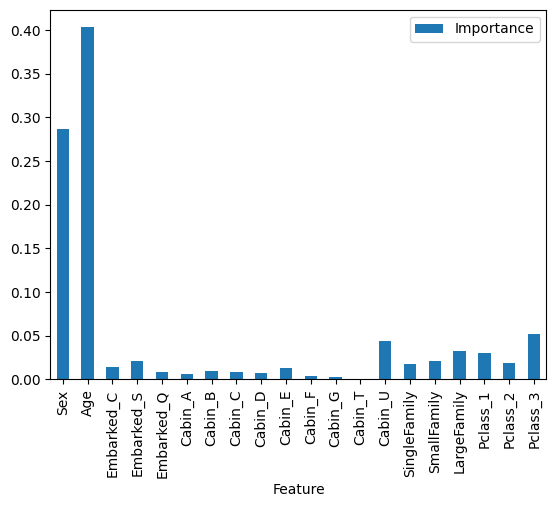

In [22]:
features = pd.DataFrame()
features['Feature'] = train.columns
features['Importance'] = clf.feature_importances_
features.set_index('Feature', inplace=True)
features.plot(kind='bar')

Great, so we can see our model seems to favor certain features over others when making it's decisions. We can use SKLearn's **SelectFromModel** class to reduce our training set to only features the model prefers.

In [23]:
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')
selectfromModel = SelectFromModel(clf, prefit=True)

model_specific_training = selectfromModel.transform(train)

#we'll do the same thing for our test data!
model_specific_testing = selectfromModel.transform(test)

print(model_specific_training.shape, model_specific_testing.shape)

(891, 3) (418, 3)


<h1>The time has finally come to test out some models!</h1>

Woot woot! Lets try a few different ones....

* Logistic Regression...maybe
* LogisticRegression CV.... ok
* Random Forest Classifiers.... alright...
* Gradient Boosting Classifier... interesting...

We'll try every one and print out it's cross-val score. The one with the best score is the one that will advance, and we'll tune some hyperparams.

In [24]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
#we already imported random forest earlier.

logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]

for model in models:
    print(f"Cross validation of {model.__class__}")
    scoreval = score(clf=model, X=model_specific_training, y=targets, scoring='accuracy')
    print(f"CV Score: {scoreval}\n_______\n")

Cross validation of <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV Score: 0.8069361621994853
_______

Cross validation of <class 'sklearn.linear_model._logistic.LogisticRegressionCV'>
CV Score: 0.8069361621994853
_______

Cross validation of <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV Score: 0.7979850605737242
_______

Cross validation of <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV Score: 0.7980164459230432
_______



Looks like logistic regression takes the cake. Lets see if we can improve performance at all by passing in some different hyperparam values.

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 0.9, 1, 1.1, 5, 10 ],
    'penalty': ['l2']
    #we wont set "solver" because our data is small, we'll stay with liblinear
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(model_specific_training, targets)

print(grid_search.best_params_)
best_model = LogisticRegression(**grid_search.best_params_)
print(score(best_model, model_specific_training, targets))
best_model.fit(model_specific_training, targets)

{'C': 0.9, 'penalty': 'l2'}
0.8069361621994853


LogisticRegression(C=0.9)

Looks like our tuned model is pretty much just using the defaults for a logistic regression model. No change in performance.

<h1>Congratulations!</h1>
<h4>We're now ready to submit the model. I'll save it as a .pkl file as well to mess around with it later, maybe work on making it into a webservice accessible by API, that way people can see if they would've survived!

Thank you for joining me on this journey of my first kaggle project. I learned a ton, and I hope you learned a bit as well. More to come!</h4>



In [26]:
predicitons = best_model.predict_proba(model_specific_testing)[:,1]
#predict_proba returns 2 things; probability of a "0" outcome (dead)
#and probability of a 1 outcome "survive". We want the second number,
#so we specify [:, 1]

predictions_df = pd.DataFrame(predicitons)
predictions_df['out'] = predictions_df.mean(axis=0)

predictions_df['PassengerId'] = pd.read_csv("./test.csv")['PassengerId']
predictions_df['Survived'] = predictions_df['out'].map(lambda s: 1 if s >= 0.5 else 0)
predictions_df = predictions_df[['PassengerId', 'Survived']]
predictions_df.T

predictions_df.to_csv("predictionsOutput.csv", index=False)

import pickle as pkl

pkl.dump(best_model, open('./savedmodel/model.pkl', 'wb'))

